In [1]:
import pandas as pd, numpy as np
from fidap import fidap_client
import config

In [2]:
fidap = fidap_client(api_key=config.FIDAP_API_KEY)

Let's first explore the data and find some basic numbers here.

In [11]:
df2 = fidap.sql("""
    select insider_trades.ticker, insider_trades.filingdate, insider_trades.transactionshares,
    insider_trades.transactionvalue, daily.close, daily.fc_1m, daily.marketcap
    from insider_trades, tickers, daily
    where 
    insider_trades.ticker = tickers.ticker and 
    insider_trades.ticker = daily.ticker and
    insider_trades.filingdate = daily.date and
    insider_trades.transactionvalue > 100000 and 
    insider_trades.securitytitle = 'Common Stock'
""")

In [12]:
df2.head()

,ticker,filingdate,transactionshares,transactionvalue,close,fc_1m,marketcap
0,CFFI,2018-08-20,-4353,270626,62.45,-0.081665,2.188000e+08
1,CFFI,2018-08-02,-8295,516364,61.90,0.012924,2.169000e+08
2,CFFI,2018-01-17,-1749,102491,58.65,-0.156010,2.046000e+08
3,CFFI,2018-01-17,-1748,102433,58.65,-0.156010,2.046000e+08
4,CFG,2017-03-27,-4164,143367,34.24,0.073890,1.743190e+10


In [5]:
len(df2)

276005

In [6]:
df2['mc_pct'] = df2['transactionvalue'] / (df2['marketcap']*1e6)

In [7]:
df2['sale'] = np.where(df2['transactionshares'] > 0, False, True)

In [8]:
df2

,ticker,filingdate,transactionshares,transactionvalue,close,fc_1m,marketcap,mc_pct,sale
0,CFFI,2018-08-20,-4353,270626,62.45,-0.081665,2.188000e+08,1.236865e-09,True
1,CFFI,2018-08-02,-8295,516364,61.90,0.012924,2.169000e+08,2.380655e-09,True
2,CFFI,2018-01-17,-1749,102491,58.65,-0.156010,2.046000e+08,5.009335e-10,True
3,CFFI,2018-01-17,-1748,102433,58.65,-0.156010,2.046000e+08,5.006500e-10,True
4,CFG,2017-03-27,-4164,143367,34.24,0.073890,1.743190e+10,8.224405e-12,True
...,...,...,...,...,...,...,...,...,...
276000,WYND,2019-05-07,-11656,519671,43.92,-0.048725,4.111700e+09,1.263884e-10,True
276001,WYND,2019-05-07,-3703,164480,43.92,-0.048725,4.111700e+09,4.000292e-11,True
276002,WYND,2020-03-02,22256,718424,40.86,-0.512726,3.567200e+09,2.013972e-10,False
276003,WYND,2020-03-02,-19380,778688,40.86,-0.512726,3.567200e+09,2.182911e-10,True


In [9]:
df2 = df2.dropna()

In [14]:
features = ['close', 'marketcap', 'mc_pct', 'sale']
label = 'fc_1m'

In [10]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [12]:
model = xgb.XGBRegressor()

In [17]:
model.fit(df2[features],df2[label])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
preds = model.predict(df2[features])

In [19]:
df2['predict'] = preds

<ipython-input-19-225561c10419>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['predict'] = preds


In [20]:
df2

,TICKER,FILINGDATE,TRANSACTIONSHARES,TRANSACTIONVALUE,CLOSE,FC_1M,MARKETCAP,mc_pct,sale,predict
0,ELVT,2017-04-12,78494,510211,7.70,0.019481,3.041000e+08,1.677774e-09,False,0.049914
1,ELVT,2017-04-12,40000,260000,7.70,0.019481,3.041000e+08,8.549819e-10,False,0.041023
2,ELVT,2017-04-17,50000,325000,8.08,-0.033416,3.192000e+08,1.018170e-09,False,0.030830
3,ELVT,2017-04-17,38460,249990,8.08,-0.033416,3.192000e+08,7.831767e-10,False,0.030830
4,ELVT,2019-04-03,-24000,105120,4.32,0.094907,1.873000e+08,5.612387e-10,True,0.026480
...,...,...,...,...,...,...,...,...,...,...
276000,RESI,2020-01-03,-13438,165825,12.62,-0.114897,6.800000e+08,2.438603e-10,True,0.007907
276001,RESI,2020-05-29,-31534,223891,7.50,0.160000,4.058000e+08,5.517275e-10,True,0.004420
276002,RESN,2019-08-13,396000,1001880,2.48,0.229839,7.040000e+07,1.423125e-08,False,0.098035
276003,REVG,2019-09-11,50000,478900,10.07,0.141013,6.264000e+08,7.645275e-10,False,0.053406


In [21]:
df2[df2['predict'] > 0]['fc_1m'].mean()

0.02671825868190371

In [22]:
df2[df2['predict'] < 0]['fc_1m'].mean()

-0.050443428344464934

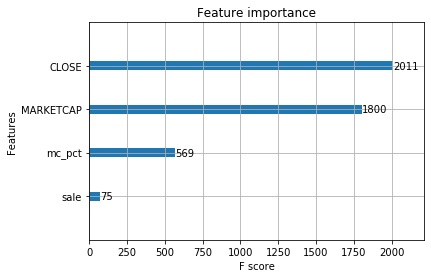

In [23]:
xgb.plot_importance(model)


# Predicting the future price using regression

### Reading in Data from Fidap

In [9]:
trading_data = fidap.sql("""
    select insider_trades.ticker, insider_trades.filingdate, insider_trades.transactionshares,
    insider_trades.transactionvalue, daily.close, daily.fc_1m, daily.marketcap
    from insider_trades, tickers, daily
    where 
    insider_trades.ticker = tickers.ticker and 
    insider_trades.ticker = daily.ticker and
    insider_trades.filingdate = daily.date and
    insider_trades.transactionvalue > 100000 and 
    insider_trades.securitytitle = 'Common Stock'
""")

In [28]:
trading_data.shape

(276005, 7)

## Split the Data into Train and Test (3:1)

In [33]:
train_df, test_df = trading_data.iloc[:184003], trading_data.iloc[184003:]

In [ ]:
train_df